In [36]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

Parse the VCF into a $({\rm variants})\times({\rm individuals})\times({\rm haplotypes})$ genotype array.
Also keep track of the positions.

In [2]:
GT = []
pos = []

with open('variants.vcf') as f:
    for line in f:
        if line.startswith('##contig'):
            # parse chromosome length
            length = int(line.split('=')[-1][:-2])
        elif line.startswith('#'):
            continue
        else:
            fields = line.split()
            GT.append([[int(allele) for allele in gt.split('|')] for gt in fields[9:]])
            pos.append(int(fields[1]))
GT = np.array(GT)
pos = np.array(pos)

In [3]:
GT.shape, pos.shape

((20911, 100, 2), (20911,))

The number of sampled haplotypes

In [4]:
n = GT.shape[1] * GT.shape[2]
n

200

Plot the SFS.
Does it look (qualitatively) like the SFS for a constant population history?

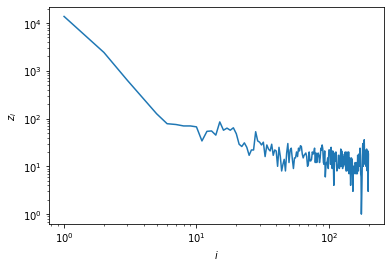

In [5]:
plt.plot(range(1, n), np.bincount(GT.sum((1, 2)), minlength=n)[1:])
plt.xlabel('$i$')
plt.ylabel('$z_i$')
plt.xscale('log')
plt.yscale('log')

For a constant size we expect a linear SFS in a log-log plot. The kink suggests something more interesting.

Divergence in 100Kb windows for the first individual

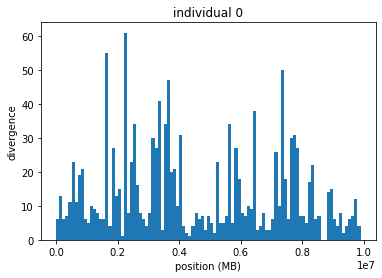

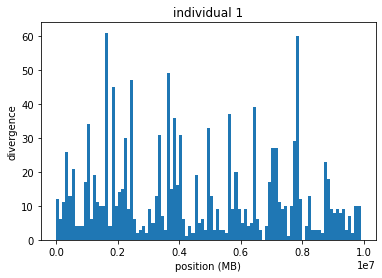

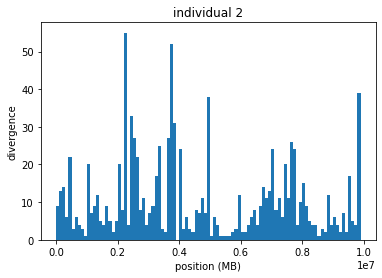

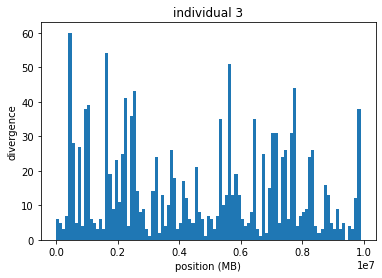

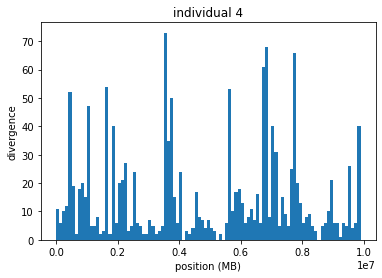

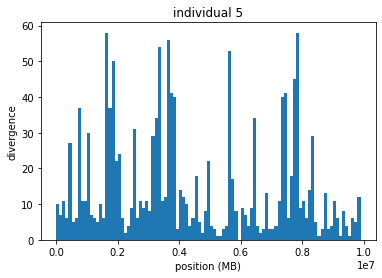

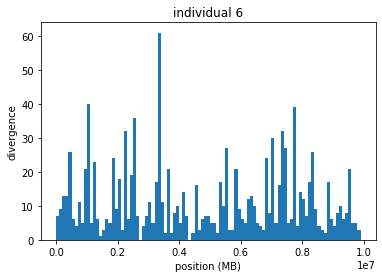

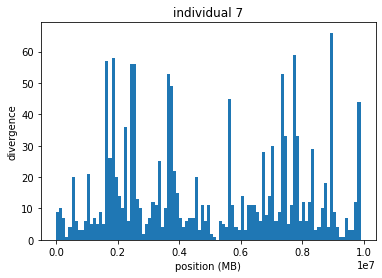

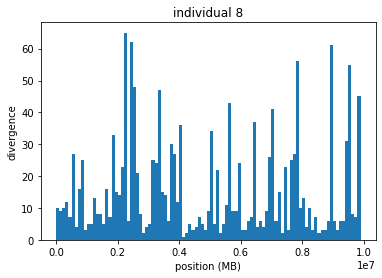

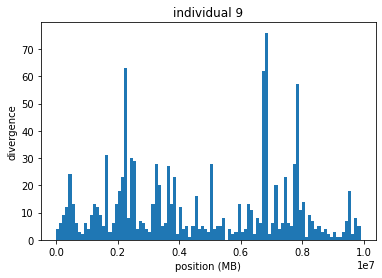

In [6]:
window_size = 100000

for indv in range(10):
    plt.hist(pos[GT[:, indv, 0] != GT[:, indv, 1]], bins=range(0, length, window_size))
    plt.xlabel(f'position (MB)')
    plt.ylabel('divergence')
    plt.title(f'individual {indv}')
    plt.show()

Write FASTA in `T/K` format with a record for first 10 diploid individuals

In [7]:
for indv in range(10):
    name = f'diploid_{indv}'
    with open(f'{name}.fasta', 'w') as f:
        x = ['T'] * length
        for i in pos[GT[:, indv, 0] != GT[:, indv, 1]]:
            x[i] = 'K'
        SeqIO.write(SeqRecord(Seq(''.join(x)),
                              id=name, description=''),
                    f, 'fasta')

Run PSMC (this will take a bit of time)

In [44]:
psmc_exe_path = 'psmc-master/psmc'

for indv in range(10):
    fasta_path = f'diploid_{indv}.fasta'
    psmc_output_path = f'diploid_{indv}.psmc '
    !{psmc_exe_path} -t 10 -N 10 -r 2 -o {psmc_output_path} {fasta_path}
    print(f'finished {indv}')

finished 0
finished 1
finished 2
finished 3
finished 4
finished 5
finished 6
finished 7
finished 8
finished 9


Parse PSMC output and plot histories

In [45]:
mu = 1e-8

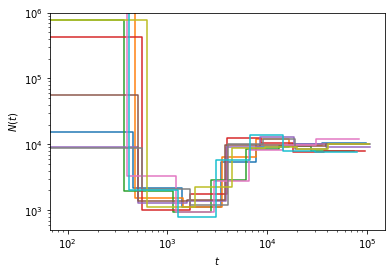

In [47]:
for indv in range(10):
    file_path = f'diploid_{indv}.psmc'
    try:
        with open(file_path) as f:
            lines = f.read().split('//')[-2].split('\n')
        t = []
        N = []
        for line in lines:
            if line.startswith('TR'):
                N0 = float(line.split()[1]) / (4 * mu)
            elif line.startswith('RS'):
                t_str, N_str = line.split()[2:4]
                t.append(2 * N0 * float(t_str))
                N.append(N0 * float(N_str))

        plt.step(t, N)
    except:
        print(f'file {file_path} does not exist')
plt.xlabel('$t$')
plt.ylabel('$N(t)$')
plt.xscale('log')
plt.yscale('log')
plt.ylim([None, 1e6]);

This population experienced a bottleneck